In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

random_state=17

from scipy.stats import skew

# Загружаем датасет, удаляем лишние данные

In [393]:
df = pd.read_excel('AirQualityUCI.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 1.1+ MB


In [394]:
df.drop(labels = ['PT08.S2(NMHC)'], axis = 1, inplace = True)

In [395]:
index_to_drop = df[df['C6H6(GT)'] == -200].index
df.drop(labels = index_to_drop, inplace = True)

In [571]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Day period,Season,Weekend
0,2.6,1360.00,11.881723,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,Mar,Evening,spring,0
1,2.0,1292.25,9.397165,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,Mar,Evening,spring,0
2,2.2,1402.00,8.997817,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,Mar,Evening,spring,0
3,2.2,1375.50,9.228796,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,Mar,Evening,spring,0
4,1.6,1272.25,6.518224,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,Mar,Evening,spring,0


# Missing data

In [396]:
# Находим показатели, для которых есть пропущенные данные
for col in df.columns[2:]:
    no_data = len(df[df[col] == -200])
    print(col, no_data)

CO(GT) 1647
PT08.S1(CO) 0
NMHC(GT) 8104
C6H6(GT) 0
NOx(GT) 1595
PT08.S3(NOx) 0
NO2(GT) 1598
PT08.S4(NO2) 0
PT08.S5(O3) 0
T 0
RH 0
AH 0


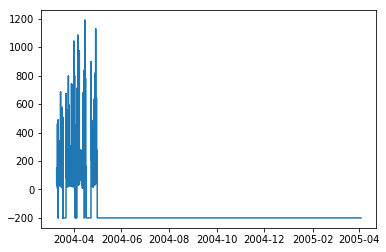

In [397]:
# Проверяем, почему отсутствует так много показателей NMHC
plt.plot(df['Date'], df['NMHC(GT)'])

In [398]:
# Данные собирались только в начале периода наблюдений, 
# так что данный показатель бесполезен при анализе целого датасета. Убираем его.
df.drop(labels = ['NMHC(GT)'], axis = 1, inplace = True)

## Моделируем значения для CO(GT), NOx(GT) и NO2(GT)

In [399]:
# Добавляем столбец "Month"
df['Month'] = df['Date'].apply(lambda x: x.month)

In [574]:
# Создаем временный датасет
temp_df = df.loc[:, 'CO(GT)':]

In [401]:
# Удаляем все отсутствующие данные
for col in temp_df.columns:
    index_to_drop = temp_df[temp_df[col] == -200].index
    temp_df.drop(labels = index_to_drop, inplace = True)

In [402]:
by_month_full = pd.pivot_table(temp_df, values=['CO(GT)', 'NOx(GT)', 'NO2(GT)'], index = 'Month', aggfunc = [np.mean, np.std])

In [12]:
by_month_full

mean                               std                       
         CO(GT)     NO2(GT)     NOx(GT)    CO(GT)    NO2(GT)     NOx(GT)
Month                                                                   
1      2.148480  138.003041  369.016892  1.452135  44.662985  240.537007
2      2.019608  158.905526  308.455793  1.198842  55.345862  193.521840
3      2.175063  124.831953  247.690617  1.376536  43.379800  174.533576
4      2.180712   99.437453  146.879963  1.419663  33.420841   86.237888
5      1.986819   95.829525  126.813708  1.193653  29.665164   67.495126
6      1.968947   98.615789  129.196491  1.148194  38.775113   79.970359
7      1.830654  103.500935  129.891589  1.093937  41.315035   84.161292
8      1.278186   66.085784   70.497549  0.562715  26.350221   44.694431
9      2.335227  108.579545  282.422727  1.468472  46.029485  171.977123
10     2.807487   91.010695  345.350267  1.624493  31.053096  184.410525
11     2.760502  123.391850  427.708464  1.933772  54.714760  291.264993
12     2.632402  121.158287  384.532588  1.654379  39.538276  231.799336

In [403]:
by_month_mean = pd.pivot_table(temp_df, values=['CO(GT)', 'NOx(GT)', 'NO2(GT)'], index = 'Month')

In [404]:
# Заполняем пропущенные данные для CO(GT), NOx(GT) и NO2(GT) в основном датасете средними значениями для соответствующего месяца
for col in ['CO(GT)', 'NOx(GT)', 'NO2(GT)']:
    index_to_replace = df[df[col] == -200].index
    for ind in index_to_replace:
        new_value = by_month_mean[col][df['Month'][ind]]
        df[col][ind] = new_value

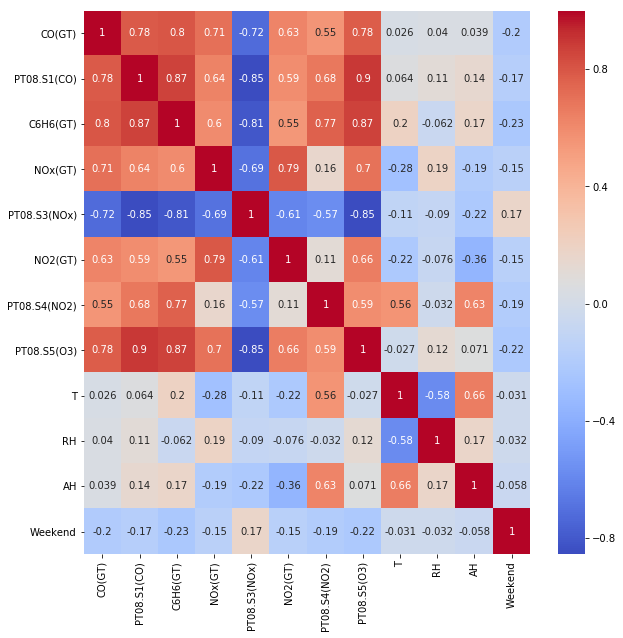

In [175]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)

# Дополнительная работа с датами

In [405]:
# Т.к. время везде дано без минут, оставляем в столбце "Time" только часы
df['Hour'] = df['Time'].apply(lambda x: x.hour)

In [406]:
# Оцениваем распределение загрязнений по часам
hours = pd.pivot_table(df, values=['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 
                                   'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'], index = 'Hour')

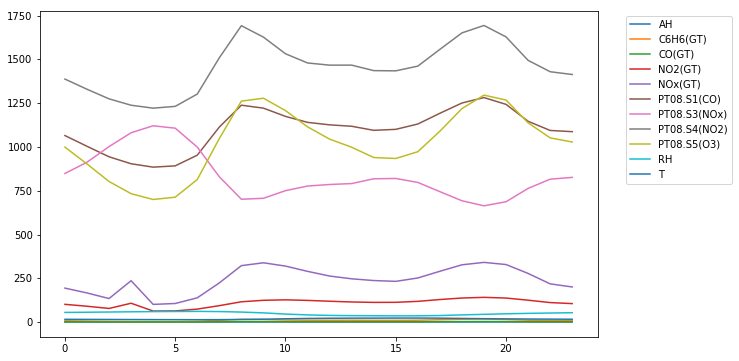

In [361]:
# Рисуем графики, чтобы определить пики выбросов в течение суток
plt.figure(figsize=(10,6))
for col in hours.columns:
    plt.plot(hours.index, hours[col])
plt.legend(bbox_to_anchor=(0.25, 0, 1, 1))

In [407]:
# Вводим переменную, отображающую время суток
Day_period = {6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Morning',
             12: 'Day', 13: 'Day', 14: 'Day', 15: 'Day', 16: 'Day',
             17: 'Evening', 18: 'Evening', 19: 'Evening', 20: 'Evening', 21: 'Evening', 22: 'Evening',
             23: 'Night', 24: 'Night', 0: 'Night', 1: 'Night', 2: 'Night', 3: 'Night', 4: 'Night', 5: 'Night'}
df['Day period'] = df.Hour.replace(Day_period)

In [408]:
df['Month'].replace({1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 
                     8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}, inplace = True)

In [409]:
# Вводим дополнительную переменную, соответствующую времени года
Season = {'Dec': 'winter', 'Jan': 'winter', 'Feb': 'winter',
         'Mar': 'spring', 'Apr': 'spring', 'May': 'spring',
         'Jun': 'summer', 'Jul': 'summer', 'Aug': 'summer',
         'Sep': 'fall', 'Oct': 'fall', 'Nov': 'fall'}
df['Season'] = df.Month.replace(Season)

In [410]:
# Вводим переменную, соответствующую дню недели
df['Day'] = df['Date'].apply(lambda x: x.dayofweek)

In [411]:
# Оцениваем распределение загрязнений по дням недели
days = pd.pivot_table(df, values=['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 
                                  'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'], index = 'Day')

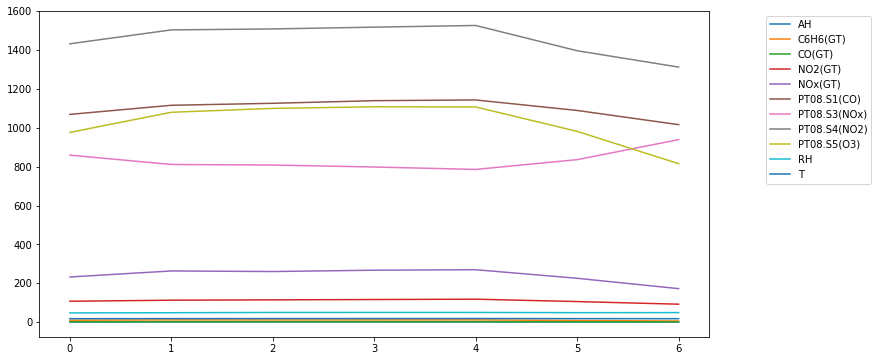

In [572]:
# Рисуем графики, чтобы определить, есть ли какие-то тренды в уровне выбросов, связанные с днями недели
plt.figure(figsize=(12,6))
for col in days.columns:
    plt.plot(days.index, days[col])
    plt.legend(bbox_to_anchor=(0.25, 0, 1, 1))

In [412]:
# Из графика следует, что наиболее высокие уровни выбросов сохраняются с понедельника по четверг.
# Вводим переменную "Weekend", которая принимает значения 1 или 0.
is_weekend = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1}
df['Weekend'] = df.Day.replace(is_weekend)

In [413]:
# Удаляем из датасета столбцы, которые тончо не будут использоваться при анализе
df.drop(labels = ['Date', 'Time', 'Day', 'Hour'], axis = 1, inplace = True)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8991 entries, 0 to 9356
Data columns (total 15 columns):
CO(GT)          8991 non-null float64
PT08.S1(CO)     8991 non-null float64
C6H6(GT)        8991 non-null float64
NOx(GT)         8991 non-null float64
PT08.S3(NOx)    8991 non-null float64
NO2(GT)         8991 non-null float64
PT08.S4(NO2)    8991 non-null float64
PT08.S5(O3)     8991 non-null float64
T               8991 non-null float64
RH              8991 non-null float64
AH              8991 non-null float64
Month           8991 non-null object
Day period      8991 non-null object
Season          8991 non-null object
Weekend         8991 non-null int64
dtypes: float64(11), int64(1), object(3)
memory usage: 1.4+ MB


In [44]:
df['PT08.S3(NOx)'].describe()

count    8991.000000
mean      835.370973
std       256.815106
min       322.000000
25%       657.875000
50%       805.500000
75%       969.250000
max      2682.750000
Name: PT08.S3(NOx), dtype: float64

# Подготовка датасета

In [414]:
df_month = pd.get_dummies(df, columns=['Month', 'Day period'])

In [415]:
y = df['C6H6(GT)']
X_month = df_month.drop(labels = ['C6H6(GT)', 'Season'], axis = 1)
X_month_train, X_month_test, y_month_train, y_month_test = train_test_split(X_month, y, test_size=0.3, random_state=random_state)

## Нормализация

In [417]:
skewed_feats = X_month.apply(lambda x: skew(x)) 

In [418]:
skewed_feats[skewed_feats > 0.75]

CO(GT)                1.427354
PT08.S1(CO)           0.755807
NOx(GT)               1.696632
PT08.S3(NOx)          1.101527
Month_Apr             2.936310
Month_Aug             3.165512
Month_Dec             3.258896
Month_Feb             3.486627
Month_Jan             3.200967
Month_Jul             3.031670
Month_Jun             3.203961
Month_Mar             2.082668
Month_May             3.066726
Month_Nov             3.094277
Month_Oct             3.031670
Month_Sep             3.145216
Day period_Day        1.434814
Day period_Evening    1.164148
Day period_Morning    1.147014
Day period_Night      0.916328
dtype: float64

In [419]:
skewed_index = ['CO(GT)', 'PT08.S1(CO)', 'NOx(GT)', 'PT08.S3(NOx)']
X_month[skewed_index] = np.log1p(X_month[skewed_index])
y = np.log1p(y)

In [435]:
X_skewed_train, X_skewed_test, y_skewed_train, y_skewed_test = train_test_split(X_month, y, test_size=0.3, random_state=random_state)

## Polynomial

In [543]:
X_skewed_train['CO(GT)2'] = X_skewed_train['CO(GT)'] ** 2
X_skewed_train['CO(GT)3'] = X_skewed_train['CO(GT)'] ** 3
X_skewed_train['PT08.S1(CO)2'] = X_skewed_train['PT08.S1(CO)'] ** 2
X_skewed_train['PT08.S1(CO)3'] = X_skewed_train['PT08.S1(CO)'] ** 3
X_skewed_train['PT08.S3(NOx)2'] = X_skewed_train['PT08.S3(NOx)'] ** 2
X_skewed_train['PT08.S4(NO2)2'] = X_skewed_train['PT08.S4(NO2)'] ** 2
X_skewed_train['PT08.S5(O3)2'] = X_skewed_train['PT08.S5(O3)'] ** 2
X_skewed_train['PT08.S5(O3)3'] = X_skewed_train['PT08.S5(O3)'] ** 3
X_skewed_train['NOx(GT)2'] = X_skewed_train['NOx(GT)'] ** 2
X_skewed_train['NO2(GT)2'] = X_skewed_train['NO2(GT)'] ** 2
X_skewed_train['CO'] = X_skewed_train['CO(GT)'] * X_skewed_train['PT08.S1(CO)']
X_skewed_train['NO2'] = X_skewed_train['NO2(GT)'] * X_skewed_train['PT08.S4(NO2)']
X_skewed_train['NOx'] = X_skewed_train['NOx(GT)'] * X_skewed_train['PT08.S3(NOx)']

In [544]:
X_skewed_test['CO(GT)2'] = X_skewed_test['CO(GT)'] ** 2
X_skewed_test['CO(GT)3'] = X_skewed_test['CO(GT)'] ** 3
X_skewed_test['PT08.S1(CO)2'] = X_skewed_test['PT08.S1(CO)'] ** 2
X_skewed_test['PT08.S1(CO)3'] = X_skewed_test['PT08.S1(CO)'] ** 3
X_skewed_test['PT08.S3(NOx)2'] = X_skewed_test['PT08.S3(NOx)'] ** 2
X_skewed_test['PT08.S4(NO2)2'] = X_skewed_test['PT08.S4(NO2)'] ** 2
X_skewed_test['PT08.S5(O3)2'] = X_skewed_test['PT08.S5(O3)'] ** 2
X_skewed_test['PT08.S5(O3)3'] = X_skewed_test['PT08.S5(O3)'] ** 3
X_skewed_test['NOx(GT)2'] = X_skewed_test['NOx(GT)'] ** 2
X_skewed_test['NO2(GT)2'] = X_skewed_test['NO2(GT)'] ** 2
X_skewed_test['CO'] = X_skewed_test['CO(GT)'] * X_skewed_test['PT08.S1(CO)']
X_skewed_test['NO2'] = X_skewed_test['NO2(GT)'] * X_skewed_test['PT08.S4(NO2)']
X_skewed_test['NOx'] = X_skewed_test['NOx(GT)'] * X_skewed_test['PT08.S3(NOx)']

# Создание и оценка модели

In [545]:
lm_skewed = LinearRegression()

In [546]:
lm_skewed.fit(X_skewed_train, y_skewed_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [547]:
cvs = []
for metric in scoring:
    cvs.append(cross_val_score(lm_skewed, X_skewed_train, y_skewed_train, cv=5, scoring=metric))
print(lm_skewed)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [548]:
for i in range(len(scoring)):
    print("%s %0.5f" % (scoring[i], cvs[i].mean()))

neg_mean_absolute_error -0.08539
neg_mean_squared_error -0.01346
neg_median_absolute_error -0.06673
r2 0.97186


# Ridge

In [549]:
best_model = lm_skewed
best_X_train = X_skewed_train
best_y_train = y_skewed_train
current_X_test = X_skewed_test
current_y_test = y_skewed_test

In [550]:
def neg_rmse_cv(model):
    rmse=cross_val_score(model, best_X_train, best_y_train, scoring="neg_mean_squared_error", cv=5)
    return(rmse)

In [559]:
alphas = [0.000001, 0.0001, 0.01, 0.05, 0.1, 0.3]
cv_ridge = [neg_rmse_cv(Ridge(alpha=alpha, random_state=random_state)).mean() for alpha in alphas]

Text(0,0.5,'neg_mse')

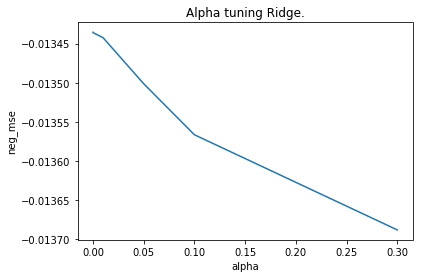

In [560]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha tuning Ridge.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

In [561]:
reg = Ridge(alpha=0.000001, random_state=random_state)

cvs = []
for metric in scoring:
    cvs.append(cross_val_score(reg, best_X_train, best_y_train, cv=5, scoring=metric))
print(reg)

Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)


In [562]:
for i in range(len(scoring)):
    print("%s %0.5f" % (scoring[i], cvs[i].mean()))

neg_mean_absolute_error -0.08540
neg_mean_squared_error -0.01344
neg_median_absolute_error -0.06680
r2 0.97191


In [567]:
lm = Ridge(alpha = 0.000001, random_state = random_state)
lm.fit(best_X_train, best_y_train)
y_pred = lm.predict(current_X_test)

Text(0,0.5,'Predicted Y')

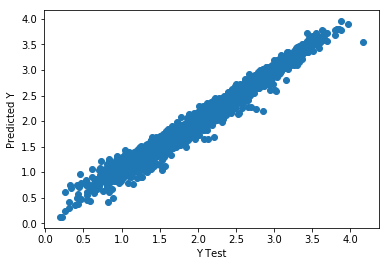

In [568]:
plt.scatter(current_y_test,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [569]:
def print_metrics(y_true, y_pred):
    print("*"*100)
    print("\nRegression metrics:\n")
    print("Mean absolute error {}".format(round(mean_absolute_error(y_true, y_pred), 4)))
    print("Mean squared error {}".format(round(mean_squared_error(y_true, y_pred), 4)))
    print("Median absolute error {}".format(round(median_absolute_error(y_true, y_pred), 4)))
    print("Explained variance score {}".format(round(explained_variance_score(y_true, y_pred), 4)))
    print("R2 score {} \n".format(round(r2_score(y_true, y_pred), 4)))
    print("*"*100)

In [570]:
print_metrics(current_y_test, y_pred)

****************************************************************************************************

Regression metrics:

Mean absolute error 0.0838
Mean squared error 0.0127
Median absolute error 0.0639
Explained variance score 0.9734
R2 score 0.9734 

****************************************************************************************************
